<a href="https://colab.research.google.com/github/andrew6881/ML-2023-10/blob/main/Student_Summary_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import keras
import random

import pandas as pd

from keras.models import load_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import seaborn as sns

%matplotlib inline

Link to blog post: https://medium.com/geekculture/nlp-with-tensorflow-keras-explanation-and-tutorial-cae3554b1290

Link to blog post on improving model: https://medium.com/@jeevanchavan143/nlp-tokenization-stemming-lemmatization-bag-of-words-tf-idf-pos-7650f83c60be

Kaggle competition page: https://www.kaggle.com/code/ryanholbrook/evaluate-student-summaries-efficiency-lb

In [ ]:
from google.colab import files
from IPython.utils import io
import os
os.system("mkdir -p ~/.kaggle")
os.system("cp kaggle.json ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")
# Place API command below to download your dataset
!kaggle competitions download -c commonlit-evaluate-student-summaries

# Use this code below to unzip any zip files contained in your dataset
with io.capture_output() as captured:
    !unzip commonlit-evaluate-student-summaries.zip

commonlit-evaluate-student-summaries.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
prompts_test = pd.read_csv("prompts_test.csv")
prompts_train = pd.read_csv("prompts_train.csv")
sample_submission = pd.read_csv("sample_submission.csv")
summaries_test = pd.read_csv("summaries_test.csv")
summaries_train = pd.read_csv("summaries_train.csv") # length 7165

In [ ]:
from keras.src.utils.text_dataset import dataset_utils
def get_submission(data):
    tweets = data["text"]
    labels = data["wording"] #2d array
    return tweets, labels
texts, labels = get_submission(summaries_train)

In [ ]:
print(summaries_train.head())

     student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757  


In [ ]:
# split training into training and validation
X = summaries_train["text"]
y = summaries_train["wording"] # prediction target
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.125, random_state = 1)

"""
train = pd.concat("prompts_train.")
test = pd.concat("prompts_test.csv", "summaries_test.csv") # concat based on prompt id
print(test)"""

'\ntrain = pd.concat("prompts_train.")\ntest = pd.concat("prompts_test.csv", "summaries_test.csv") # concat based on prompt id\nprint(test)'

In [ ]:
# tokenize each text

texts = [text for text in X_train]

tokenizer = Tokenizer(num_words=650, oov_token='<UNK>')
tokenizer.fit_on_texts(texts)

maxlen = 650
def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, truncating = 'post', padding='post', maxlen=maxlen)
    return padded

In [ ]:
a = max(X_train, key = lambda x: len(x.split()))
len(a.split())

647

In [ ]:
padded_train_seq = get_sequences(tokenizer, texts)

In [ ]:
targets = "wording"

model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000,16,input_length=maxlen),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
tf.keras.layers.Dense(1, activation='linear')
])

model.compile(
     loss='mean_squared_error',
     optimizer='adam',
     metrics=['accuracy']
)

In [ ]:
val_seq = get_sequences(tokenizer, X_valid)
val_labels= targets
h = model.fit(
     padded_train_seq, y_train,
     validation_data=(val_seq, y_valid),
     epochs=20,
     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)]
)

Epoch 1/20
196/196 [==============================] - 214s 1s/step - loss: 0.7147 - accuracy: 0.0000e+00 - val_loss: 0.4662 - val_accuracy: 0.0000e+00
Epoch 2/20
196/196 [==============================] - 192s 980ms/step - loss: 0.4507 - accuracy: 0.0000e+00 - val_loss: 0.4134 - val_accuracy: 0.0000e+00
Epoch 3/20
196/196 [==============================] - 192s 981ms/step - loss: 0.4154 - accuracy: 0.0000e+00 - val_loss: 0.3842 - val_accuracy: 0.0000e+00
Epoch 4/20
196/196 [==============================] - 198s 1s/step - loss: 0.3865 - accuracy: 0.0000e+00 - val_loss: 0.3777 - val_accuracy: 0.0000e+00
Epoch 5/20
196/196 [==============================] - 192s 980ms/step - loss: 0.3743 - accuracy: 0.0000e+00 - val_loss: 0.3901 - val_accuracy: 0.0000e+00


In [ ]:
results = model.predict(val_seq)

28/28 [==============================] - 7s 178ms/step


In [ ]:
print(results[:,0])

<Axes: ylabel='wording'>

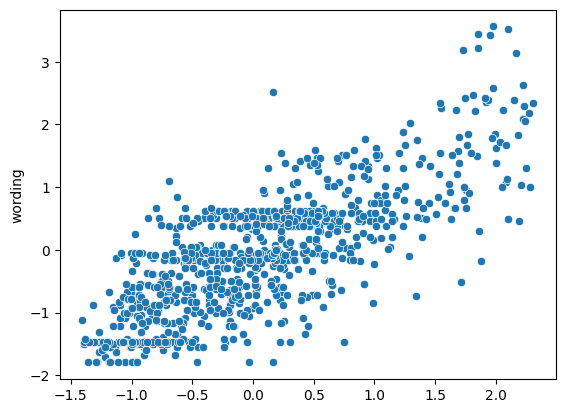

In [ ]:
# plot results against y_valid
sns.scatterplot(x = results[:,0], y = y_valid)